Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/20250114/fig/20250114_001054_Run1_VIGO17_NS089008_QPD_20_20_AS_015_CC_QPDGapScan_KnifeEdge_Z21839um_fit.png
Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/20250114/fig/20250114_002516_Run1_VIGO17_NS089008_QPD_20_20_AS_015_CC_QPDGapScan_KnifeEdge_Z21844um_fit.png
Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/20250114/fig/20250114_003941_Run1_VIGO17_NS089008_QPD_20_20_AS_015_CC_QPDGapScan_KnifeEdge_Z21849um_fit.png
Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/20250114/fig/20250114_005404_Run1_VIGO17_NS089008_QPD_20_20_AS_015_CC_QPDGapScan_KnifeEdge_Z21854um_fit.png
Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/20250114/fig/20250114_010828_Run1_VIGO17_NS089008_QPD_20_20_AS_015_CC_QPDGapScan_KnifeEdge_Z21859um_fit.png
Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/2025

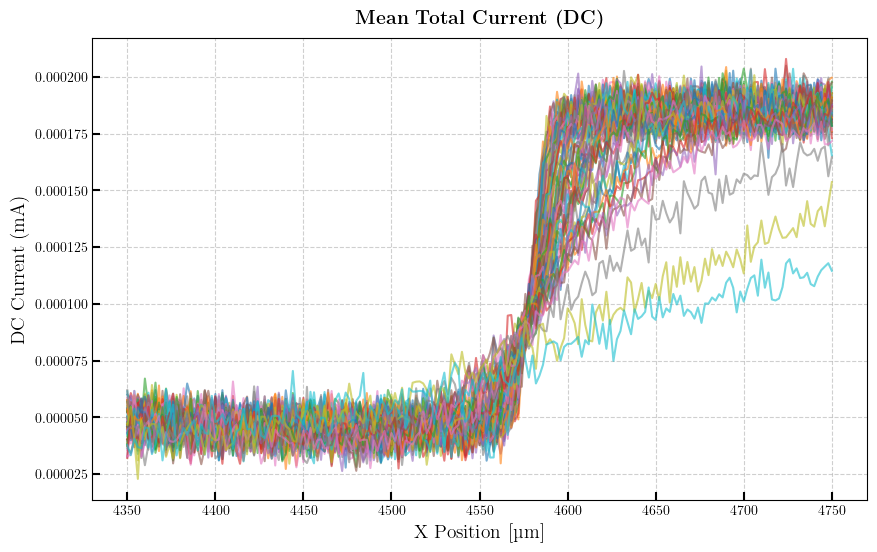

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/20250114/fig/combined_error_functions.png


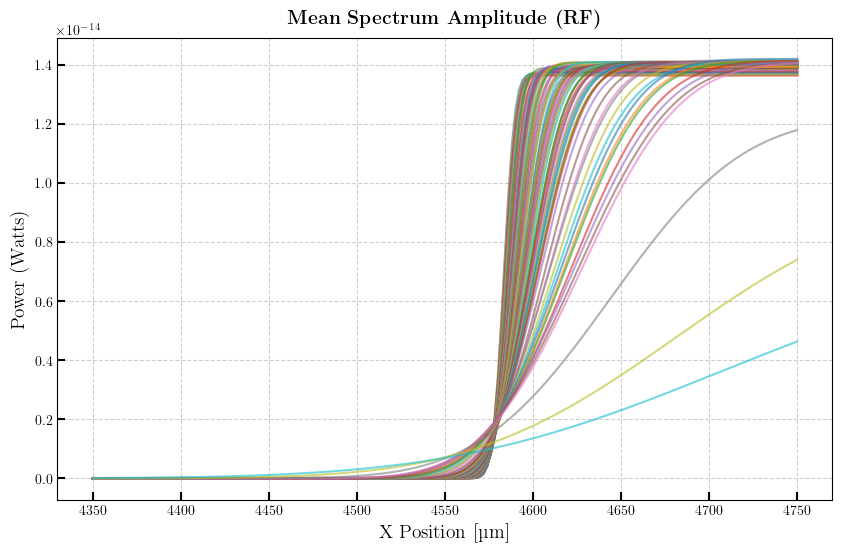

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/20250114/fig/combined_spectrum_peak_curves.png


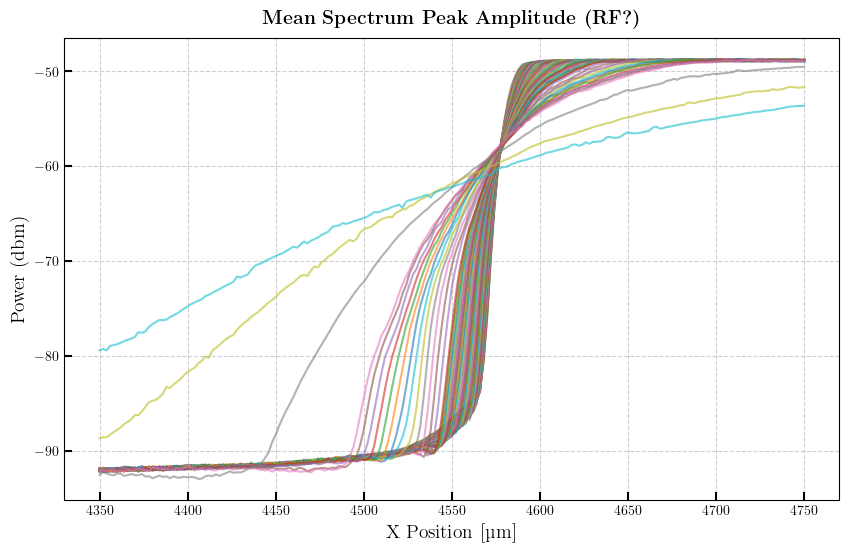

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/20250114/fig/beam_waist_vs_z.png


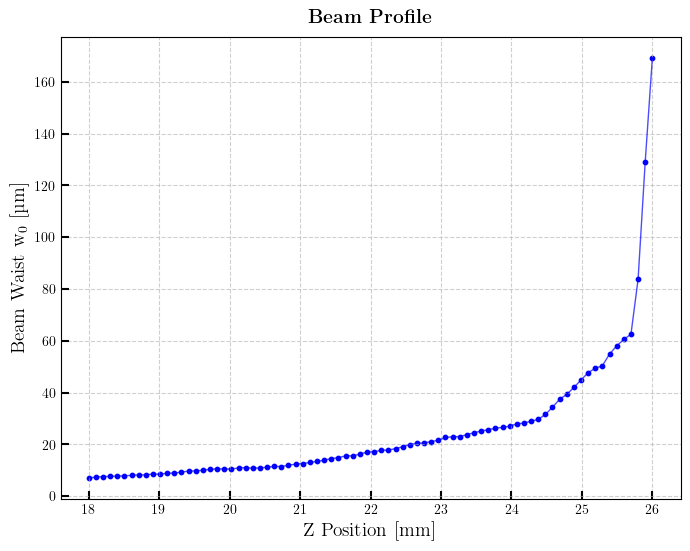

In [1]:
import pickle
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import scipy.optimize as opt
from scipy.special import erf

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
'''plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.6'''

# Define the error function model
def error_function(x, A, B, C, D):
    return A * (0.5 + 0.5 * erf((x - C) / (np.sqrt(2) * B))) + D

# Data directories
data_dir = "/Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/20250114"
fig_dir = os.path.join(data_dir, "fig")
os.makedirs(fig_dir, exist_ok=True)

# Load .pkl files
file_list = sorted(glob.glob(os.path.join(data_dir, "*.pkl")))

def load_data(file_path):
    with open(file_path, "rb") as file:
        return pickle.load(file)

# Determine z values dynamically
if file_list:
    first_file = load_data(file_list[0])
    z_start = first_file['global_params']['zstart_um']
    z_stop = first_file['global_params']['zstop_um']
    num_files = len(file_list)
    
    # Generate z_values matching the number of .pkl files
    z_values = np.linspace(z_start, z_stop, num_files)
else:
    z_values = []
    
# Arrays to store beam waist values and corresponding z positions
w0_values = []
all_x_positions = []
all_fitted_curves = []
all_dc_curves = []  
all_sgl_curves = []

for i, file_path in enumerate(file_list):
    data = load_data(file_path)
    rawdata = data.get('rawdata', None)
    global_params = data.get('global_params', None)
    
    if rawdata is None or global_params is None:
        print(f"Skipping {file_path}, missing 'rawdata' or 'global_params'.")
        continue
    
    # Extract scan direction
    x_start, x_stop = global_params['xstart_um'], global_params['xstop_um']
    y_start, y_stop = global_params['ystart_um'], global_params['ystop_um']
    
    if y_start == y_stop:
        scan_direction = "horizontal"
        x_positions = np.arange(x_start, x_stop + global_params['xystep_um'], global_params['xystep_um'])
    else:
        scan_direction = "vertical"
        x_positions = np.arange(y_start, y_stop + global_params['xystep_um'], global_params['xystep_um'])
    
    # Extract power spectrum data and compute power in watts
    RBW_Hz = 10e3  # 10 kHz
    power_dbm_RBW = rawdata['quadA']['spa_trace_dbm']
    power_dbm_hz = power_dbm_RBW - 10 * np.log10(RBW_Hz)
    power_watts = 10 ** ((power_dbm_hz - 30) / 10)
    power_watts_avg = np.mean(power_watts, axis=(1, 2))
    
    if len(x_positions) != len(power_watts_avg):
        print(f"Error: x_positions and power_watts_avg length mismatch for {file_path}.")
        continue
    
    # Fit the error function model
    initial_guess = [np.max(power_watts_avg) - np.min(power_watts_avg), 10, np.mean(x_positions), np.min(power_watts_avg)]
    params, _ = opt.curve_fit(error_function, x_positions, power_watts_avg, p0=initial_guess)
    A_fit, B_fit, C_fit, D_fit = params
    spot_size = np.sqrt(2) * B_fit  # Beam waist estimation
    
    # Store corresponding z-value and beam waist
    current_z = z_values[i]
    w0_values.append(spot_size)
    
    # Compute the fitted error function values
    fitted_curve = error_function(x_positions, *params)
    all_x_positions.append(x_positions)
    all_fitted_curves.append(fitted_curve)
    
    # Save individual fits
    plt.figure(figsize=(10, 6))
    plt.scatter(x_positions, power_watts_avg, label='Measured Data', color='b', marker='o',s=30)
    plt.plot(x_positions, fitted_curve, label='Fitted Error Function', linestyle='-', color='r', linewidth=2)
    plt.xlabel(r'X Position [\textmu{}m]', fontsize=14)
    plt.ylabel('Power (Watts)', fontsize=14)
    #plt.title(rf'Power vs. X Position (Z={current_z:.2f} $\mu$m)', fontsize=16)
    title = rf"\textbf{{Power vs. X Position (Z= {current_z:.2f} \textmu{{m}}}}"
    plt.title(title, fontsize=14, fontweight='bold', pad=10)
    plt.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0.05, 0.98), frameon=True)
    plt.tick_params(axis='both', which='major', labelsize=10, length=6, width=1.5, direction='in')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    filename = os.path.basename(file_path).replace(".pkl", "_fit.png")
    save_path = os.path.join(fig_dir, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Saved: {save_path}")
    plt.close()

    #### DC CURRENT SIGNAL & PEAK DBM SIGNAL
    # Extract DC current signal (like you did for the RF signal)
    dc_current = rawdata['quadA']['dmm00_curr_amp']  # DC current signal data
    peak_sgl = rawdata['quadA']['spa_peak1_dbm'] # Peak signal data
    
    # Compute the DC current average (assuming the same x_positions)
    #print(dc_current.shape)
    dc_current_avg = np.mean(dc_current, axis=1)  # Average across the correct dimensions
    all_dc_curves.append(dc_current_avg)
    '''# Fit the error function model for DC current
    initial_guess_dc = [np.max(dc_current_avg) - np.min(dc_current_avg), 10, np.mean(x_positions), np.min(dc_current_avg)]
    params_dc, _ = opt.curve_fit(error_function, x_positions, dc_current_avg, p0=initial_guess_dc)
    A_fit_dc, B_fit_dc, C_fit_dc, D_fit_dc = params_dc
    spot_size_dc = np.sqrt(2) * B_fit_dc  # Beam waist for DC current'''
    # Compute the DC current average (assuming the same x_positions)
    #print(peak_sgl.shape)
    peak_sgl_avg = np.mean(peak_sgl, axis=1)  # Average across the correct dimensions
    all_sgl_curves.append(peak_sgl_avg)


# Convert w0_values to proper arrays
w0_values = np.array(w0_values)
z_values = np.array(z_values)
print(w0_values)
print(z_values)
print(w0_values.shape, z_values.shape)

#### Plot all dc curves together
plt.figure(figsize=(10, 6))
for x_vals, curve in zip(all_x_positions, all_dc_curves):
    plt.plot(x_vals, curve, linestyle='-', alpha=0.6)
plt.xlabel(r'X Position [\textmu{}m]', fontsize=14)
plt.ylabel('DC Current (mA)', fontsize=14)
title = rf"\textbf{{Mean Total Current (DC)}}"
plt.title(title, fontsize=14, fontweight='bold', pad=10)
plt.tick_params(axis='both', which='major', labelsize=10, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
error_fit_path = os.path.join(fig_dir, "combined_current_curves.png")
plt.savefig(error_fit_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {error_fit_path}")
plt.show()

### Plot all error function fits together, implement these cosmetics above
plt.figure(figsize=(10, 6))
for x_vals, curve in zip(all_x_positions, all_fitted_curves):
    plt.plot(x_vals, curve, linestyle='-', alpha=0.6)
plt.xlabel(r'X Position [\textmu{}m]', fontsize=14)
plt.ylabel('Power (Watts)', fontsize=14)
title = rf"\textbf{{Mean Spectrum Amplitude (RF)}}"
plt.title(title, fontsize=14, fontweight='bold', pad=10)
plt.tick_params(axis='both', which='major', labelsize=10, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)

error_fit_path = os.path.join(fig_dir, "combined_error_functions.png")
plt.savefig(error_fit_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {error_fit_path}")
plt.show()

#### Plot all spa_peak1_dbm curves together
plt.figure(figsize=(10, 6))
for x_vals, curve in zip(all_x_positions, all_sgl_curves):
    plt.plot(x_vals, curve, linestyle='-', alpha=0.6)
plt.xlabel(r'X Position [\textmu{}m]', fontsize=14)
plt.ylabel('Power (dbm)', fontsize=14)
title = rf"\textbf{{Mean Spectrum Peak Amplitude (RF?)}}"
plt.title(title, fontsize=14, fontweight='bold', pad=10)
plt.tick_params(axis='both', which='major', labelsize=10, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
error_fit_path = os.path.join(fig_dir, "combined_spectrum_peak_curves.png")
plt.savefig(error_fit_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {error_fit_path}")
plt.show()

# Plot beam waist (w0) against z positions
plt.figure(figsize=(8, 6))
plt.scatter(z_values, w0_values, color='b', marker='o', s=10, label="Estimated Beam Waist")
plt.plot(z_values, w0_values, linestyle='-', color='b', linewidth=1, alpha=0.7)  # Add a connecting line
plt.xlabel(r"Z Position [mm]", fontsize=14)
plt.ylabel(r"Beam Waist $\rm{w}_0$ [\textmu{}m]", fontsize=14)
title = rf"\textbf{{Beam Profile}}"
plt.title(title, fontsize=14, fontweight='bold', pad=10)
plt.tick_params(axis='both', which='major', labelsize=10, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)

# Save the figure if needed
waist_plot_path = os.path.join(fig_dir, "beam_waist_vs_z.png")
plt.savefig(waist_plot_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {waist_plot_path}")

plt.show()